In [1]:
import copy
import functools

from matplotlib import pyplot as plt
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML

import jax
import optax
import numpy as np
import tensorflow as tf

from acme import specs
from acme.tf.savers import SaveableAdapter

import contrastive
from contrastive.config import ContrastiveConfig
from contrastive import utils as contrastive_utils
from contrastive import make_networks
from contrastive.utils import make_environment
from contrastive import ContrastiveLearner
from contrastive.builder import create_maze_dataset_iterator
from tqdm import tqdm

# disable tensorflow_probability warning: The use of `check_types` is deprecated and does not have any effect.
import logging
logger = logging.getLogger("root")

class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()

logger.addFilter(CheckTypesFilter())

2024-07-23 16:24:22.493627: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yongweic/.conda/envs/contrastive_rl/lib:/home/yongweic/.mujoco/mujoco210/bin:/usr/lib/nvidia:/home/yongweic/.mujoco/mujoco200/bin:/home/yongweic/.mujoco/mujoco200/bin
No module named 'flow'
No module named 'carla'
pybullet build time: Nov 28 2023 23:52:03
/home/yongweic/.conda/envs/contrastive_rl/lib/python3.9/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [2]:
def getConfig(env_name, ckpt_dir):
    params = {
      'use_random_actor': True,
      'entropy_coefficient': None if 'image' in env_name else 0.0,
      'env_name': env_name,
      # For online RL experiments, max_number_of_steps is the number of
      # environment steps. For offline RL experiments, this is the number of
      # gradient steps.
      'max_number_of_steps': 1_000_000,
      'use_image_obs': 'image' in env_name,
    }
    if 'ant_' in env_name:
        params['end_index'] = 2

    # 2. Select an algorithm. The currently-supported algorithms are:
    # contrastive_nce, contrastive_cpc, c_learning, nce+c_learning, gcbc.
    # Many other algorithms can be implemented by passing other parameters
    # or adding a few lines of code.
    alg = 'contrastive_nce'
    if alg == 'contrastive_nce':
        pass  # Just use the default hyperparameters
    elif alg == 'contrastive_cpc':
        params['use_cpc'] = True
    elif alg == 'c_learning':
        params['use_td'] = True
        params['twin_q'] = True
    elif alg == 'nce+c_learning':
        params['use_td'] = True
        params['twin_q'] = True
        params['add_mc_to_td'] = True
    elif alg == 'gcbc':
        params['use_gcbc'] = True
    else:
        raise NotImplementedError('Unknown method: %s' % alg)

    # For the offline RL experiments, modify some hyperparameters.
    if env_name.startswith('offline_ant'):
        params.update({
            # Effectively remove the rate-limiter by using very large values.
            'samples_per_insert': 1_000_000,
            'samples_per_insert_tolerance_rate': 100_000_000.0,
            # For the actor update, only use future states as goals.
            'random_goals': 0.0,
            'bc_coef': 0.05,  # Add a behavioral cloning term to the actor.
            'twin_q': True,  # Learn two critics, and take the minimum.
            'batch_size': 1024,  # Increase the batch size 256 --> 1024.
            'repr_dim': 16,  # Decrease the representation size 64 --> 16.
            # Increase the policy network size (256, 256) --> (1024, 1024)
            'hidden_layer_sizes': (1024, 1024),
        })
        print('hi')
        
    config = ContrastiveConfig(**params)
    config.critic_learning_rate = 0.001
    obs_dim = make_environment(env_name, config.start_index, config.end_index, seed=0)[1]

    network_factory = functools.partial(
      contrastive.make_networks, 
        obs_dim=obs_dim, 
        repr_dim=config.repr_dim,
      repr_norm=config.repr_norm, 
        twin_q=config.twin_q,
      use_image_obs=config.use_image_obs,
      hidden_layer_sizes=config.hidden_layer_sizes)

    env_factory = lambda seed: make_environment(
      env_name, config.start_index, config.end_index, seed)[0]
    dummy_seed = 1
    environment_spec = specs.make_environment_spec(
        env_factory(dummy_seed))
    random_key = jax.random.PRNGKey(np.random.choice(int(1e6)))
    networks = network_factory(environment_spec)
    policy_optimizer = optax.adam(
      learning_rate=config.actor_learning_rate)
    q_optimizer = optax.adam(
      learning_rate=config.critic_learning_rate)
    l_optimizer = optax.adam(
        learning_rate=config.critic_learning_rate
    )

    trained_learner = ContrastiveLearner(
      networks=networks,
      rng=random_key,
      policy_optimizer=policy_optimizer,
      q_optimizer=q_optimizer,
      l_optimizer=l_optimizer,
      iterator=None,
      counter=None,
      logger=None,
      config=config,
      obs_to_goal=None,
      l_iterator=None
    )

    ckpt = tf.train.Checkpoint(learner=SaveableAdapter(trained_learner))
    ckpt_mgr = tf.train.CheckpointManager(
        ckpt, ckpt_dir, 1)
    ckpt.restore(ckpt_mgr.latest_checkpoint)

    trained_learner_state = trained_learner._state

    print("Model loaded from: {}".format(ckpt_dir))

    return config, trained_learner, env_factory, networks, environment_spec

In [10]:
env_name = "point_FourRooms"
ckpt_dir = "/home/yongweic/acme/52ec6ac2-4922-11ef-9af7-ec2a72227f18/checkpoints/learner"

config, trained_learner, env_factory, networks, env_spec = getConfig(env_name, ckpt_dir)
iterator = create_maze_dataset_iterator(config)
trained_learner_state = trained_learner._state

scaling_factor = config.scaling_factor
maze_shape = config.maze_shape

maze_shape: (8, 8)
Model loaded from: /home/yongweic/acme/52ec6ac2-4922-11ef-9af7-ec2a72227f18/checkpoints/learner


In [11]:
# example usage
env = env_factory(np.random.randint(1e6))

obs = env.reset().observation[None,:]
print(obs.shape)
print(f'cur: {obs[:,:2]}, goal: {obs[:,-2:]}')

q_params = trained_learner_state.q_params

action=np.zeros((1,2))

sa_repr, g_repr, (state, goal) = networks.repr_fn(q_params, obs=obs, action=action)

(1, 4)
cur: [[2.8639956 4.259392 ]], goal: [[9.692768 5.029451]]


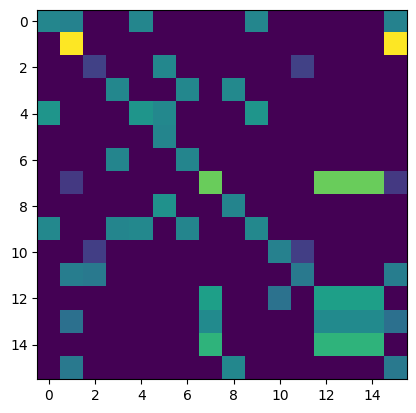

In [12]:
sample = next(iterator)

g_repr, l_repr, outer = networks.l_network.apply(trained_learner_state.l_params, sample[1][:16,:], sample[0][:16,:])

plt.imshow(np.exp(outer))

In [13]:
import jax.numpy as jnp

def l_loss(l_params, 
          l_data):
    language, goal = l_data
    batch_size = language.shape[0]

    I = jnp.eye(batch_size)  # pylint: disable=invalid-name
    _, _, logits = networks.l_network.apply(l_params, goal, language)

    def loss_fn(_logits):  # pylint: disable=invalid-name
        if config.use_cpc:
            return (optax.softmax_cross_entropy(logits=_logits, labels=I)
                  + 0.01 * jax.nn.logsumexp(_logits, axis=1)**2)
        else:
            return optax.sigmoid_binary_cross_entropy(logits=_logits, labels=I)

    loss = loss_fn(logits)
    loss = jnp.mean(loss)

    # correct = (jnp.argmax(logits, axis=1) == jnp.argmax(I, axis=1))
    # logits_pos = jnp.sum(logits * I) / jnp.sum(I)
    # logits_neg = jnp.sum(logits * (1 - I)) / jnp.sum(1 - I)

    return loss

In [14]:
# sanity check
loss = l_loss(trained_learner_state.l_params, next(iterator))

print(f'LOSS: {loss}')

LOSS: 0.0039595975540578365


In [ ]:
def grid_search_action(env, networks, q_params, obs, num_samples=5, category=None):
    action_low, action_high = env.action_space.low, env.action_space.high
    action_dim = env.action_space.shape[0]
    grid = [np.linspace(action_low[i], action_high[i], num_samples) for i in range(action_dim)]
    action_grid = np.array(np.meshgrid(*grid)).T.reshape(-1, action_dim)
    best_action = None
    best_dot_product = -np.inf
    
    if category:
        one_hot = np.zeros(maze_shape)
        one_hot[category] = 1
        one_hot = one_hot[None,:]
        g_repr, _, _ = networks.l_network.apply(trained_learner_state.l_params, np.zeros((1, 2)), one_hot)
    else:
        _, g_repr, _ = networks.repr_fn(q_params, obs=obs, action=np.zeros((1, 2)))

    
    for action in action_grid:
        # Compute representations
        action = np.array(action, dtype=np.float32)
        sa_repr, _, _ = networks.repr_fn(q_params, obs=obs, action=action[None, :])
        
        # Compute dot product
        # print(f'here: {g_repr.shape}')
        dot_product = np.dot(sa_repr.flatten(), g_repr.flatten())

        if dot_product > best_dot_product:
            best_dot_product = dot_product
            best_action = action

    # Step the environment with the best action
    transition = env.step(best_action)

    return transition

def run_episode(env, networks, q_params, n_steps=1, num_samples=1, categorical=False):
    obs = env.reset().observation[None,:]
    
    category=None
    if categorical:
        category = np.random.randint(0, 16)
    
    
    total_reward = 0
    done = False
    
    for step in tqdm(range(n_steps)):
#         print(f"\nStep {step + 1}/{n_steps}")
#         print(f"Current observation: {obs[:,:2]}, Goal: {obs[:,-2:]}")
        
        transition = grid_search_action(env, networks, q_params, obs, num_samples, category=category)
        
        obs = transition.observation[None,:]
        # print(obs[:,:2])
        # points.append(obs[0,:2])
        
        cur = obs[0,:2]
        goal = obs[0,-2:]
        
        
        if categorical:
            # print(f'category: {category} and position: {cur}')
            cond1 = category < 8 and category == int(cur[0])
            cond2 = category >= 8 and category == int(cur[1]) - 8
            if cond1 or cond2:
                done = True
                break
        else:
            if np.linalg.norm(cur - goal) < 0.5:
                done= True
                break
        
    
    return done

# Example usage:
NUM_TRIALS = 5
success_rate = 0
for i in range(NUM_TRIALS):
    done = run_episode(env, networks, q_params, n_steps=25, num_samples=10, categorical=True)
    success_rate += done
print(f'success: {success_rate / NUM_TRIALS}')

In [ ]:
p = np.array(points)
plt.scatter(p[:,0], p[:,1])

In [ ]:
p.shape

In [ ]:
sa_repr, g_repr, (state, goal) = networks.repr_fn(q_params, obs=obs, action=action)

In [ ]:
NUM_EPISODES = 25

env = env_factory(np.random.randint(1e6))
obs_dim = env.observation_spec().shape[0] // 2
episode_returns = np.zeros([NUM_EPISODES, ])

timesteps = []
for epi in range(NUM_EPISODES):
    t = 0
    env.seed(epi)  # use fixed seed for different methods
    timestep = env.reset()
    episode_return = 0
    
    # print(f'start state: {timestep.observation[:2]}, goal: {timestep.observation[-2:]}')
    # goal = [5.9277008955091254, 8.699144684746049]

    while not timestep.last():
        obs = timestep.observation
        # print(obs.shape)
        # obs[-2:] = goal
        dist = networks.policy_network.apply(
          trained_learner_state.policy_params,
          timestep.observation
        )
        action = np.array(dist.mode())
        # print(action)
        timestep = env.step(action)
        timesteps.append(timestep)

        # Book-keeping.
        t += 1
        episode_return += timestep.reward

    # assert t == env._step_limit
    # print("episode length = {}".format(t))
    episode_returns[epi] = episode_return

print("avg episode return: {}".format(np.mean(episode_returns)))
print("success rate: {}".format(np.mean(episode_returns >= 1)))

In [ ]:
points = []
for timestep in timesteps:
    points.append(timestep.observation[:2])
    
points = np.array(points)
plt.scatter(points[:,0], points[:,1])

In [ ]:
points